In [1]:
'''
Goal: seperate the scoial interaction datatset, then create the change graphs for cntx and generic weeks

'''
import pandas as pd

# --- Load and clean ---
df = pd.read_csv("feat_dataset_filtered_with_weeks.csv")
df.columns = df.columns.str.replace(' ', '_')

# --- Define your activity columns ---
activity_cols = [
    'call_in_duration_ep_0', 'call_out_duration_ep_0',
    'call_in_num_ep_0', 'call_out_num_ep_0',
    'loc_food_convo_duration', 'loc_food_convo_num', 'loc_food_still',
    'loc_greek_dur', 'loc_home_dur', 'loc_home_convo_duration', 'loc_home_convo_num',
    'loc_other_dorm_dur', 'loc_self_dorm_dur', 'loc_study_dur',
    'sms_in_num_ep_0', 'sms_out_num_ep_0'
    
]

# --- Keep only columns that exist ---
activity_cols = [c for c in activity_cols if c in df.columns]


# --- Compute per-participant averages for Week 1, 6, 7,8 ---
per_uid_week = (
    df[df['week_per_uid'].isin([1, 6,7,8])]
    .groupby(['uid', 'week_per_uid'])[activity_cols]
    .mean(numeric_only=True)
    .reset_index()
)

print(per_uid_week)
per_uid_week.to_csv("avg_socialInt_data_week.csv")

               uid  week_per_uid  call_in_duration_ep_0  \
0   t0002@sreflect             1               8.428571   
1   t0002@sreflect             6               0.000000   
2   t0002@sreflect             7               0.000000   
3   t0002@sreflect             8               0.000000   
4   t0003@sreflect             1             249.285714   
..             ...           ...                    ...   
63  t0019@sreflect             6               0.000000   
64  t0020@sreflect             1              13.428571   
65  t0020@sreflect             6               9.500000   
66  t0022@sreflect             1              30.571429   
67  t0022@sreflect             6              16.200000   

    call_out_duration_ep_0  call_in_num_ep_0  call_out_num_ep_0  \
0                40.000000          0.428571           0.714286   
1                 0.000000          0.000000           0.000000   
2                 0.000000          0.000000           0.000000   
3                 0.000

/var/folders/r1/_8ps3x2x6nb6r77rz8dp80sh0000gn/T/ipykernel_22069/760810680.py:8: DtypeWarning: Columns (427) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("feat_dataset_filtered_with_weeks.csv")


In [2]:
'''now use the social int dataset to convert all the values into same unit'''
import pandas as pd

# Load dataset
df = pd.read_csv("avg_socialInt_data_week.csv")

# Columns in different units
seconds_cols = ['call_in_duration_ep_0', 'call_out_duration_ep_0']
minutes_cols = ['loc_food_convo_duration', 'loc_food_still', 'loc_home_convo_duration']
hours_cols = ['loc_greek_dur', 'loc_home_dur', 'loc_other_dorm_dur',
              'loc_self_dorm_dur', 'loc_study_dur']

# Convert seconds to hours
for col in seconds_cols:
    for week in ['w1', 'w6', 'w7','w8']:
        c = f"{col}_{week}"
        if c in df.columns:
            df[c] = df[c] / 3600.0

# Convert minutes to hours
for col in minutes_cols:
    for week in ['w1', 'w6','w7', 'w8']:
        c = f"{col}_{week}"
        if c in df.columns:
            df[c] = df[c] / 60.0
            
# Save converted version to new file
df.to_csv("social_dataset_converted_to_hours.csv", index=False)

print("Saved converted dataset as 'social_dataset_converted_to_hours.csv'")

Saved converted dataset as 'social_dataset_converted_to_hours.csv'


In [9]:
'''since all the social interation features are different types, using standardscale method to have them into one unit
like giving a social score

z = (x - u) / s
where u is the mean of the training samples or zero if with_mean=False, and s 
is the standard deviation of the training samples or one if with_std=False.


'''


from sklearn.preprocessing import StandardScaler
import pandas as pd

social_cols = [
    'call_in_duration_ep_0', 'call_out_duration_ep_0',
    'call_in_num_ep_0', 'call_out_num_ep_0',
    'loc_food_convo_duration', 'loc_food_convo_num', 'loc_food_still',
    'loc_greek_dur', 'loc_home_dur', 'loc_home_convo_duration', 'loc_home_convo_num',
    'loc_other_dorm_dur', 'loc_self_dorm_dur', 'loc_study_dur',
    'sms_in_num_ep_0', 'sms_out_num_ep_0'
]

# just in case some blanks got read as strings
for col in social_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df['week_per_uid'] = df['week_per_uid'].astype(int)

for col in social_cols:
    df[col + "_z"] = df.groupby("week_per_uid")[col].transform(
        lambda x: (x - x.mean()) / x.std(ddof=0)
    )

z_cols = [c + "_z" for c in social_cols]
df["social_index"] = df[z_cols].mean(axis=1)

wide = df.pivot_table(
    index="uid",
    columns="week_per_uid",
    values="social_index"
)

wide = wide.rename(columns={
    1: "social_index_w1",
    6: "social_index_w6",
    7: "social_index_w7",
    8: "social_index_w8"
})

wide["social_change_cntx"] = wide["social_index_w6"] - wide["social_index_w1"]
wide["social_change_generic"] = wide["social_index_w8"] - wide["social_index_w7"]

wide.head()



week_per_uid,social_index_w1,social_index_w6,social_index_w7,social_index_w8,social_change_cntx,social_change_generic
uid,,,,,,
t0002@sreflect,0.668990,-0.607075,-0.669932,-0.567844,-1.276065,0.102088
t0003@sreflect,0.376955,0.060138,0.374600,0.509051,-0.316817,0.134451
t0004@sreflect,0.706188,0.697202,0.865688,0.830206,-0.008986,-0.035482
t0005@sreflect,-0.335912,-0.293809,-0.494698,-0.655839,0.042102,-0.161140
t0006@sreflect,-0.431016,-0.296433,-0.236771,0.086269,0.134583,0.323040


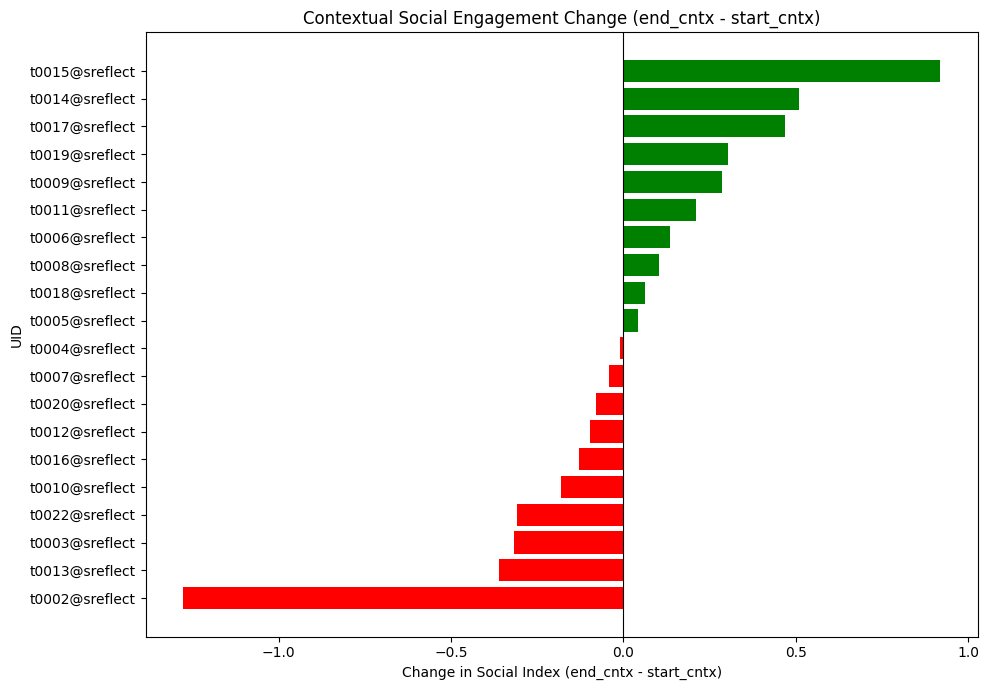

In [13]:
import matplotlib.pyplot as plt

# Use the wide dataframe and drop users missing either week
plot_df = wide.dropna(subset=["social_index_w1", "social_index_w6"]).copy()

# Compute change if not already present
plot_df["social_change_cntx"] = (
    plot_df["social_index_w6"] - plot_df["social_index_w1"]
)

# Sort for nicer visualization
plot_df = plot_df.sort_values("social_change_cntx")

# Color scheme: green = positive, red = negative
colors = plot_df["social_change_cntx"].apply(
    lambda x: "green" if x > 0 else "red"
)

plt.figure(figsize=(10, 7))
plt.barh(
    plot_df.index,
    plot_df["social_change_cntx"],
    color=colors
)

plt.xlabel("Change in Social Index (end_cntx - start_cntx)")
plt.ylabel("UID")
plt.title("Contextual Social Engagement Change (end_cntx - start_cntx)")
plt.axvline(0, color="black", linewidth=0.8)

plt.tight_layout()
plt.show()


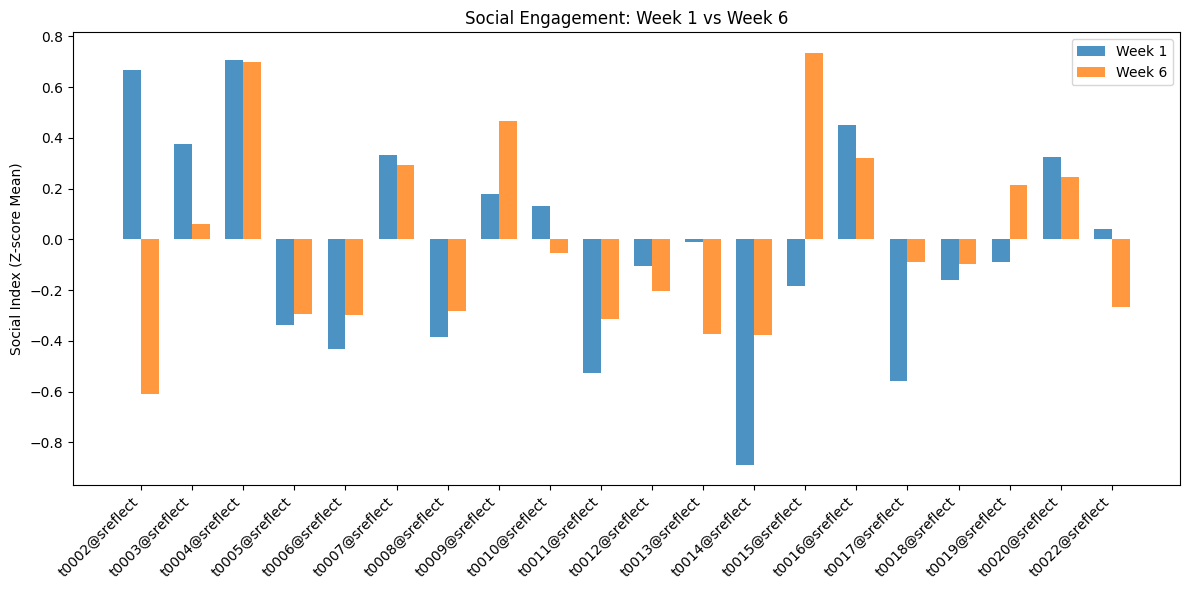

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Keep only users who have both week 1 and week 6
plot_df = wide.dropna(subset=["social_index_w1", "social_index_w6"])

uids = plot_df.index.tolist()
w1 = plot_df["social_index_w1"].values
w6 = plot_df["social_index_w6"].values

x = np.arange(len(uids))  # positions for each uid
width = 0.35              # width of each bar

plt.figure(figsize=(12, 6))

plt.bar(x - width/2, w1, width, label='Week 1', alpha=0.8)
plt.bar(x + width/2, w6, width, label='Week 6', alpha=0.8)

plt.xticks(x, uids, rotation=45, ha='right')
plt.ylabel("Social Index (Z-score Mean)")
plt.title("Social Engagement: Week 1 vs Week 6")
plt.legend()

plt.tight_layout()
plt.show()


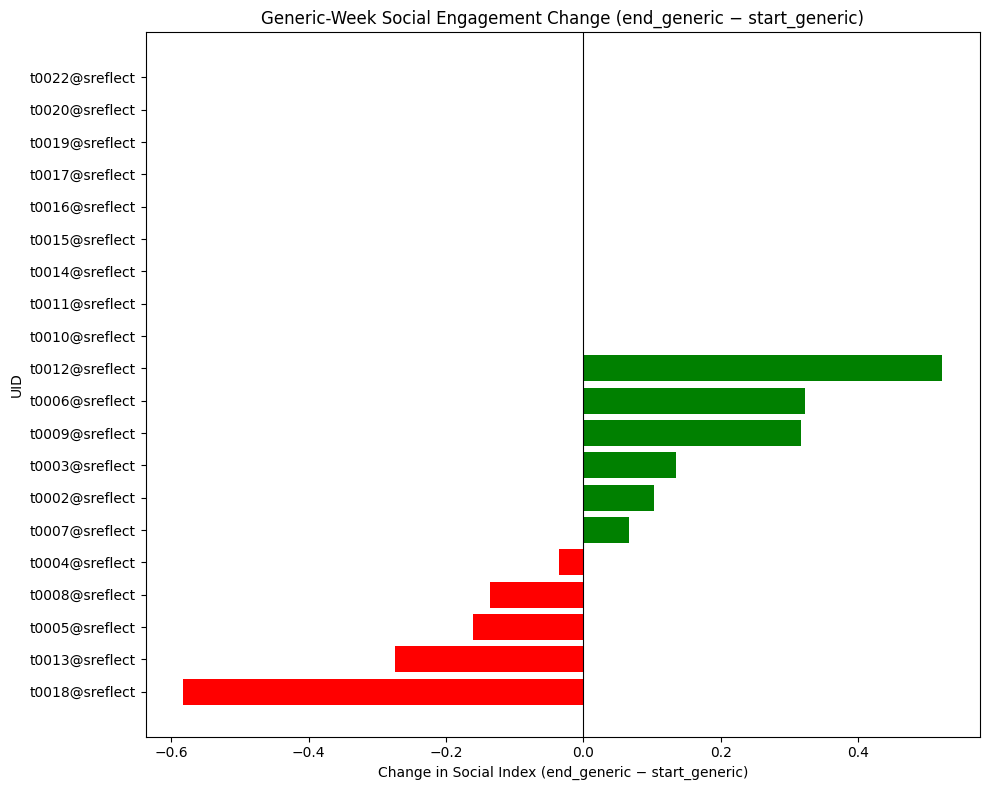

In [19]:
'''generic week data '''

import matplotlib.pyplot as plt
import numpy as np

# Keep all users
plot_df = wide.copy()

# Compute change
plot_df["social_change_generic"] = (
    plot_df["social_index_w8"] - plot_df["social_index_w7"]
)

# Sort by change (NaNs go last)
plot_df = plot_df.sort_values("social_change_generic", na_position="last")

# Colors:
# green = positive change
# red = negative change
# grey = missing data
colors = plot_df["social_change_generic"].apply(
    lambda x: "green" if pd.notna(x) and x > 0 
    else ("red" if pd.notna(x) and x < 0 else "grey")
)

# Replace NaN with 0 ONLY for bar length so all users appear
values = plot_df["social_change_generic"].fillna(0)

plt.figure(figsize=(10, 8))
plt.barh(
    plot_df.index,
    values,
    color=colors
)

plt.xlabel("Change in Social Index (end_generic − start_generic)")
plt.ylabel("UID")
plt.title("Generic-Week Social Engagement Change (end_generic − start_generic)")
plt.axvline(0, color="black", linewidth=0.8)

plt.tight_layout()
plt.show()


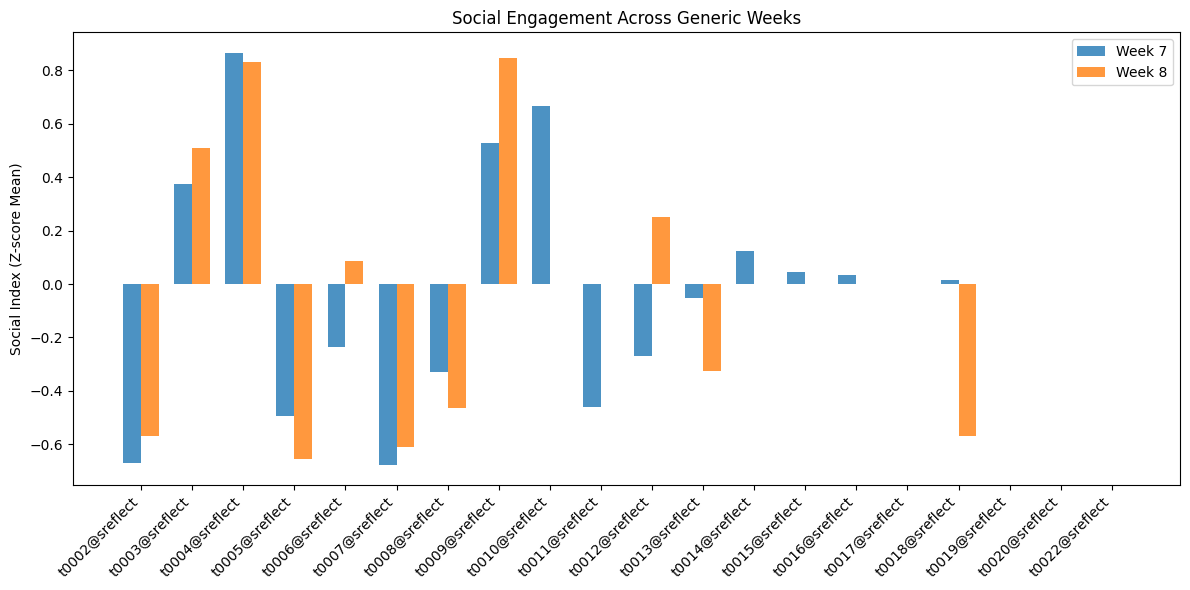

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Work on full dataset (NO dropna)
plot_df = wide.copy()

# Replace NaN with 0 for plotting only
plot_df["w7_plot"] = plot_df["social_index_w7"].fillna(0)
plot_df["w8_plot"] = plot_df["social_index_w8"].fillna(0)

# Compute change (optional)
plot_df["social_change_generic"] = (
    plot_df["social_index_w8"] - plot_df["social_index_w7"]
)

uids = plot_df.index.tolist()
w7 = plot_df["w7_plot"].values
w8 = plot_df["w8_plot"].values

x = np.arange(len(uids))
width = 0.35

plt.figure(figsize=(12, 6))

plt.bar(x - width/2, w7, width, label='Week 7', alpha=0.8)
plt.bar(x + width/2, w8, width, label='Week 8', alpha=0.8)

plt.xticks(x, uids, rotation=45, ha='right')
plt.ylabel("Social Index (Z-score Mean)")
plt.title("Social Engagement Across Generic Weeks")
plt.legend()

plt.tight_layout()
plt.show()
